In [19]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import sys

sys.path.append("../")

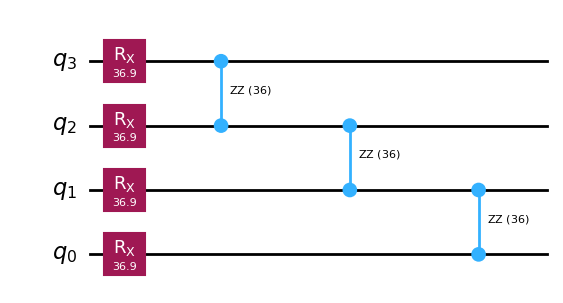

In [21]:
### QMSE scheme ###

import numpy as np
from rdkit import Chem
from quantum_molecular_encodings.supporting_functions import coulomb_matrix, matrix_to_circuit

# Example SMILES string
smiles_string = "CCCC"

molecule_from_smiles = Chem.MolFromSmiles(smiles_string)
num_qubits = molecule_from_smiles.GetNumAtoms()

# Generate the Coulomb matrix without hydrogen atoms
coulomb_matrix_without_h = coulomb_matrix(smiles_string, add_hydrogens=False)

# Encoding circuit #TODO: test with different n_atom_to_qubit values
circuit = matrix_to_circuit(coulomb_matrix_without_h, num_qubits = num_qubits, entangling_layer='rzz', n_atom_to_qubit=1, interleaved='rzz', reverse_bits=True, n_layers=1)
circuit.draw(reverse_bits=True, output='mpl')

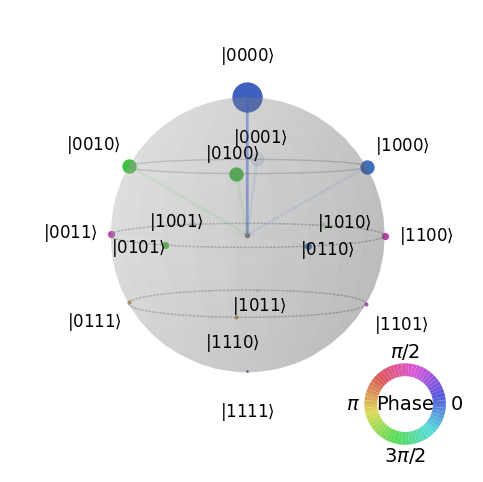

In [22]:
from qiskit.visualization import plot_state_qsphere
from qiskit.quantum_info import Statevector

statevector = np.array(Statevector(circuit))
plot_state_qsphere(statevector, figsize=(6, 6))

In [23]:
### RDKit Fingerprint similarity for comparison ###

from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import DataStructs
import pandas as pd

# Define the SMILES strings for the alkanes
smiles_list = np.array(["CC","CCC", "CCCC", "CCCCC", "CCCCCC", "CCCCCCC", "CCCCCCCC", "CCCCCCCCC", "CCCCCCCCCC"])
# smiles_list = np.array(["C1CC1", "C1CCC1", "C1CCCC1", "C1CCCCC1", "C1CCCCCC1", "C1CCCCCCC1", "C1CCCCCCCC1", "C1CCCCCCCCC1"])
# smiles_list = np.array(["C=C/C=C/CC#N", "C=CC(=C)CC#N"])
# smiles_list = np.array(['c1ccccc1', 'c1c2ccccc2ccc1', 'c1ccc2cc3ccccc3cc2c1', 'c1c2cc3cc4ccccc4cc3cc2ccc1', 'c1c2cc3cc4cc5ccccc5cc4cc3cc2ccc1'])

# Convert SMILES strings to RDKit molecules
molecules = np.array([Chem.MolFromSmiles(smile) for smile in smiles_list])


# Find the molecule with the largest number of atoms
num_qubits = max(mol.GetNumAtoms() for mol in molecules if mol is not None)

# Generate fingerprints for each molecule
fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=2048)
# fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=4, includeChirality=True, fpSize=2048)
fingerprints = ([fpgen.GetFingerprint(mol) for mol in molecules])

# Calculate Tanimoto similarity matrix
n = len(fingerprints)
tanimoto_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i != j:
            tanimoto_matrix[i][j] = DataStructs.FingerprintSimilarity(fingerprints[i], fingerprints[j])
        else:
            tanimoto_matrix[i][j] = 1.0  # Similarity with itself is 1

# Display the Tanimoto similarity matrix
tanimoto_df = pd.DataFrame(tanimoto_matrix, index=smiles_list, columns=smiles_list)
tanimoto_df

,CC,CCC,CCCC,CCCCC,CCCCCC,CCCCCCC,CCCCCCCC,CCCCCCCCC,CCCCCCCCCC
CC,1.000000,0.500000,0.333333,0.250000,0.200000,0.166667,0.142857,0.142857,0.142857
CCC,0.500000,1.000000,0.666667,0.500000,0.400000,0.333333,0.285714,0.285714,0.285714
CCCC,0.333333,0.666667,1.000000,0.750000,0.600000,0.500000,0.428571,0.428571,0.428571
CCCCC,0.250000,0.500000,0.750000,1.000000,0.800000,0.666667,0.571429,0.571429,0.571429
CCCCCC,0.200000,0.400000,0.600000,0.800000,1.000000,0.833333,0.714286,0.714286,0.714286
CCCCCCC,0.166667,0.333333,0.500000,0.666667,0.833333,1.000000,0.857143,0.857143,0.857143
CCCCCCCC,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.000000,1.000000,1.000000
CCCCCCCCC,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.000000,1.000000,1.000000
CCCCCCCCCC,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.000000,1.000000,1.000000


In [24]:
### QMSE similarities ###

from quantum_molecular_encodings.supporting_functions import quantum_overlap

overlap_df_x_xx = quantum_overlap(num_qubits, smiles_list, entangling_layer = 'rxx', n_atom_to_qubit=1, interleaved='ryy', n_layers=1)
overlap_df_x_yy = quantum_overlap(num_qubits, smiles_list, entangling_layer = 'ryy', n_atom_to_qubit=1, interleaved='ryy', n_layers=1)
#TODO: test with different n_atom_to_qubit values
overlap_df_x_zz = quantum_overlap(num_qubits, smiles_list, entangling_layer = 'rzz', n_atom_to_qubit=1, interleaved='ryy', n_layers=1)
overlap_df = pd.DataFrame(overlap_df_x_zz, index=smiles_list, columns=smiles_list)
overlap_df

,CC,CCC,CCCC,CCCCC,CCCCCC,CCCCCCC,CCCCCCCC,CCCCCCCCC,CCCCCCCCCC
CC,1.000000,0.572275,0.476909,0.397436,0.331205,0.276012,0.230017,0.191686,0.159743
CCC,0.572275,1.000000,0.572275,0.476909,0.397436,0.331205,0.276012,0.230017,0.191686
CCCC,0.476909,0.572275,1.000000,0.572275,0.476909,0.397436,0.331205,0.276012,0.230017
CCCCC,0.397436,0.476909,0.572275,1.000000,0.572275,0.476909,0.397436,0.331205,0.276012
CCCCCC,0.331205,0.397436,0.476909,0.572275,1.000000,0.572275,0.476909,0.397436,0.331205
CCCCCCC,0.276012,0.331205,0.397436,0.476909,0.572275,1.000000,0.572275,0.476909,0.397436
CCCCCCCC,0.230017,0.276012,0.331205,0.397436,0.476909,0.572275,1.000000,0.572275,0.476909
CCCCCCCCC,0.191686,0.230017,0.276012,0.331205,0.397436,0.476909,0.572275,1.000000,0.572275
CCCCCCCCCC,0.159743,0.191686,0.230017,0.276012,0.331205,0.397436,0.476909,0.572275,1.000000


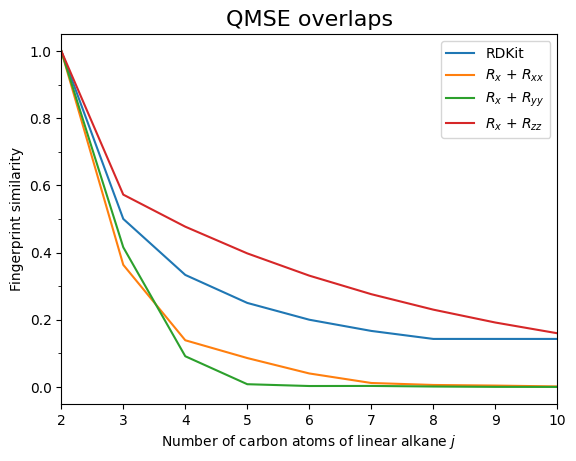

In [25]:
### Visualisation QMSE vs RDKit similarities ###

from matplotlib import pyplot as plt

x_low = 2 # "CC"
x_high = 10 # "CCCCCCCCCC"
x = np.arange(x_low,x_high+1,1)
fig, ax = plt.subplots()

ax.plot(x, tanimoto_matrix[0, :])
ax.plot(x, overlap_df_x_xx[0, :])
ax.plot(x, overlap_df_x_yy[0, :])
ax.plot(x, overlap_df_x_zz[0, :])
ax.set_xticks(x, minor=True)
ax.set_yticks(np.arange(0, 1.1, 0.1), minor=True)
ax.set_title('QMSE overlaps', fontsize=16)
ax.set_xlabel('Number of carbon atoms of linear alkane $j$')
ax.set_ylabel('Fingerprint similarity')
ax.set_xlim(x_low, x_high)
ax.legend(['RDKit', '$R_x$ + $R_{xx}$', '$R_x$ + $R_{yy}$', '$R_x$ + $R_{zz}$'])
# ax.legend(['RDKit', '$R_x$ + CX + $R_{xx}$', '$R_x$ + CX + $R_{yy}$', '$R_x$ + CX + $R_{zz}$'])
ax.tick_params(axis='x', which='both', top=False)
ax.tick_params(axis='y', which='both', right=False)
# plt.savefig("figure_aromatic3.pdf", format="pdf", dpi=2000)



In [26]:
### smaller smiles_list for demonstration of noisy sampler ###




smiles_list = np.array(["CC","CCC", "CCCC", "CCCCC"])
molecules = np.array([Chem.MolFromSmiles(smile) for smile in smiles_list])
num_qubits = max(mol.GetNumAtoms() for mol in molecules if mol is not None)


fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=2048)
fingerprints = ([fpgen.GetFingerprint(mol) for mol in molecules])

n = len(fingerprints)
tanimoto_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i != j:
            tanimoto_matrix[i][j] = DataStructs.FingerprintSimilarity(fingerprints[i], fingerprints[j])
        else:
            tanimoto_matrix[i][j] = 1.0  # Similarity with itself is 1


tanimoto_df = pd.DataFrame(tanimoto_matrix, index=smiles_list, columns=smiles_list)
tanimoto_df

,CC,CCC,CCCC,CCCCC
CC,1.000000,0.500000,0.333333,0.25
CCC,0.500000,1.000000,0.666667,0.50
CCCC,0.333333,0.666667,1.000000,0.75
CCCCC,0.250000,0.500000,0.750000,1.00


In [ ]:
### QMSE with noisy backends ###

from qiskit_ibm_runtime.fake_provider import FakeTorino
from quantum_molecular_encodings.supporting_functions import quantum_sampler_overlap

num_shots = 1000
backend = FakeTorino()
sampler_df_x_xx = quantum_sampler_overlap(num_shots, backend, smiles_list, entangling_layer = 'rxx', n_atom_to_qubit=1, interleaved='cz', n_layers=3)
sampler_df_x_yy = quantum_sampler_overlap(num_shots, backend, smiles_list, entangling_layer = 'ryy', n_atom_to_qubit=1, interleaved='cz', n_layers=3)
sampler_df_x_zz = quantum_sampler_overlap(num_shots, backend, smiles_list, entangling_layer = 'rzz', n_atom_to_qubit=1, interleaved='cz', n_layers=3)
sampler_df = pd.DataFrame(sampler_df_x_xx, index=smiles_list, columns=smiles_list)
sampler_df

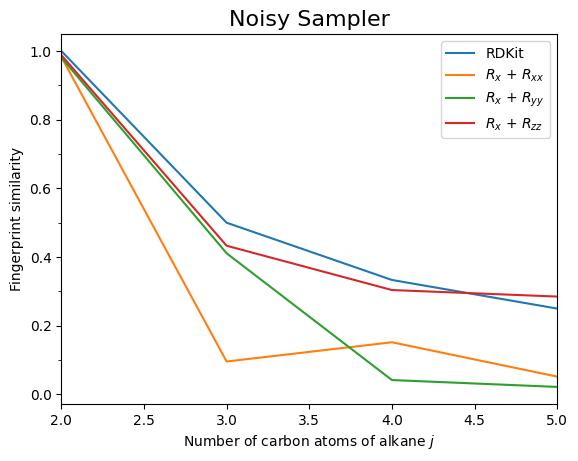

In [ ]:
x_low = 2
x_high = 5
x = np.arange(x_low,x_high+1,1)
fig, ax = plt.subplots()
ax.plot(x, tanimoto_matrix[0, :])
ax.plot(x, sampler_df_x_xx[0, :])
ax.plot(x, sampler_df_x_yy[0, :])
ax.plot(x, sampler_df_x_zz[0, :])
ax.set_xticks(x, minor=True)
ax.set_yticks(np.arange(0, 1.1, 0.1), minor=True)
ax.set_title('Noisy Sampler', fontsize=16)
ax.set_xlabel('Number of carbon atoms of alkane $j$')
ax.set_ylabel('Fingerprint similarity')
ax.set_xlim(x_low, x_high)
# ax.legend(['RDKit', '$R_x$ + $R_{xx}$', '$R_x$ + $R_{yy}$', '$R_x$ + $R_{zz}$'])
ax.legend(['RDKit', '$R_x$ + $R_{xx}$', '$R_x$ + $R_{yy}$', '$R_x$ + $R_{zz}$'])
ax.tick_params(axis='x', which='both', top=False)
ax.tick_params(axis='y', which='both', right=False)
plt.show()
